In [46]:
#some necessery library and connecting drive
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import  drive 
from google.colab.patches import cv2_imshow
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
#unzipping
!unzip "/content/drive/MyDrive/data2.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/data2.zip
replace /content/data/data/in_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

(467, 700, 3)
(467, 700, 3)


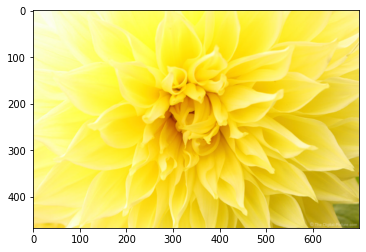

In [215]:
#reading images
image=cv2.imread("data/data/in_09.png")
img1=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
target=cv2.imread("data/data/tar_09.png")
imgt1=cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
plt.imshow(img1)
#Due to some size differences, I resize the target image to the same size as the source image.
imgt2 = cv2.resize(imgt1, (img1.shape[1], img1.shape[0]))
print(img1.shape)
print(imgt2.shape)

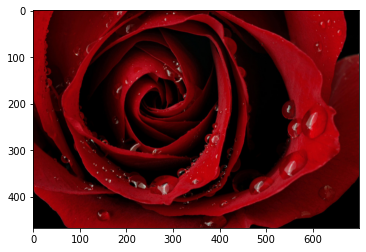

In [216]:
plt.imshow(imgt2)

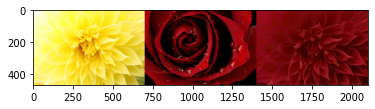

In [217]:
image=cv2.imread("data/data/res_09.png")
res=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
resimg=cv2.hconcat([img1,imgt2,res])
#resimg=cv2.cvtColor(resimg,cv2.COLOR_BGR2RGB)
plt.imshow(resimg)
plt.savefig("result2.png")

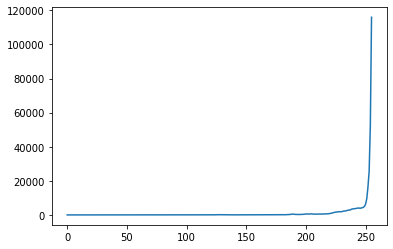

In [218]:
#lets look at histogram graphics
histr = cv2.calcHist([img1],[0],None,[256],[0,256])
histr1 = cv2.calcHist([imgt2],[0],None,[256],[0,256])
plt.plot(histr)
plt.savefig('hstrs.png')
plt.show()

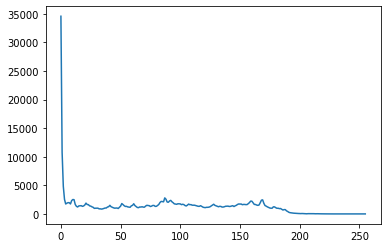

In [219]:
plt.plot(histr1)
plt.savefig('hstrt.png')
plt.show()

In [220]:
#splitting images l, a, b color space
img=cv2.cvtColor(img1,cv2.COLOR_RGB2LAB)
imgt=cv2.cvtColor(imgt2,cv2.COLOR_RGB2LAB)
sl,sa,sb=cv2.split(img)
tl,ta,tb=cv2.split(imgt)

In [221]:
def mean_std(l,a,b):
  lmean,lstd,amean,astd,bmean,bstd=l.mean(),l.std(),a.mean(),a.std(),b.mean(),b.std()
  return [lmean,lstd,amean,astd,bmean,bstd]

In [222]:
#implememtation of transferring target image color to source image 
source=mean_std(sl,sa,sb)
target=mean_std(tl,ta,tb)
sl=sl-source[0]
sa=sa-source[2]
sb=sb-source[4]
l=sl*(source[1]/target[1])
a=sa*(source[3]/target[3])
b=sb*(source[5]/target[5])
l+=target[0]
a+=target[2]
b+=target[4]
l=np.clip(l,0,255)
a=np.clip(a,0,255)
b=np.clip(b,0,255)
transfer=cv2.merge([l,a,b])#merge color scales
res=cv2.cvtColor(transfer.astype("uint8"),cv2.COLOR_LAB2RGB)#transform LAB to RGB

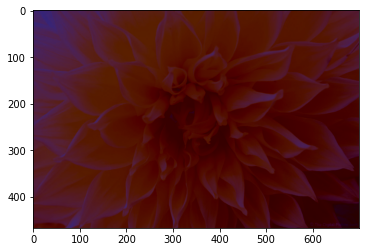

In [223]:
plt.imshow(res)

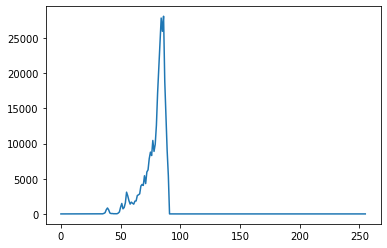

In [224]:
#histogram graphics for result image
histr2 = cv2.calcHist([res],[0],None,[256],[0,256])
plt.plot(histr2)
plt.savefig('hstrres.png')
plt.show()

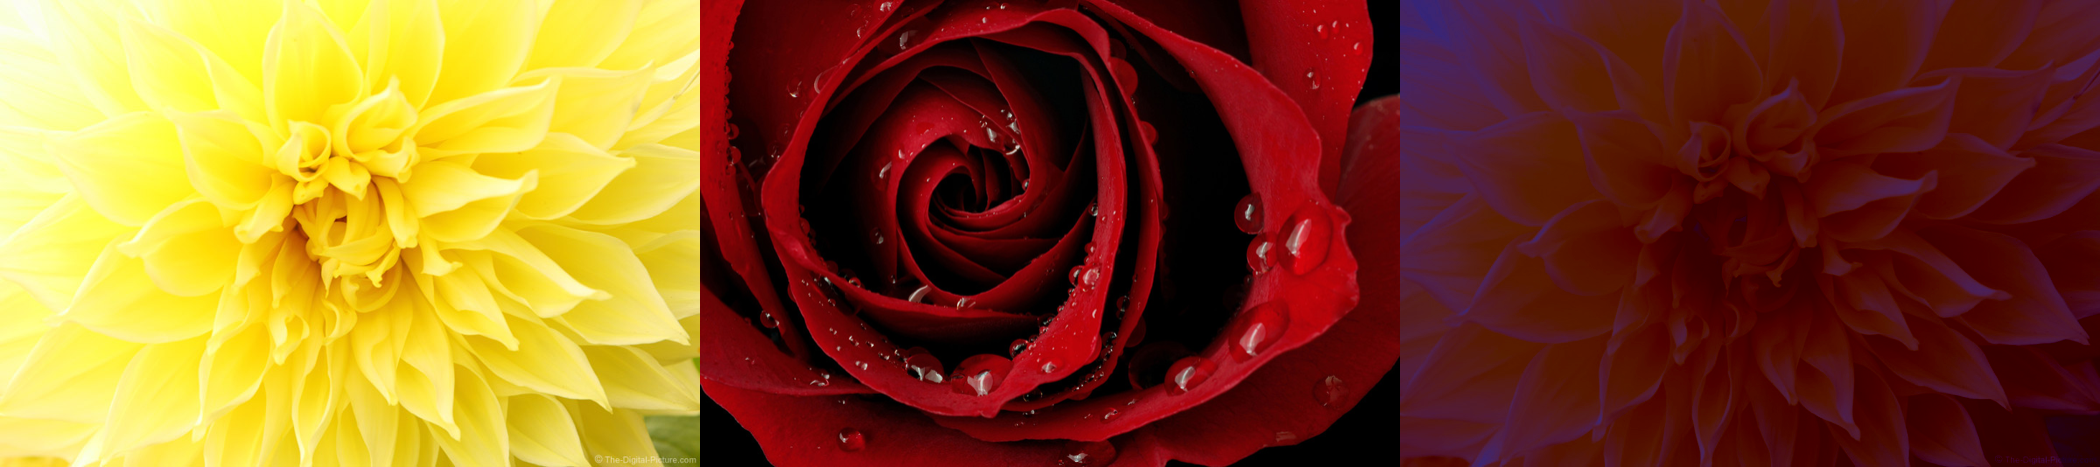

In [225]:
resimg=cv2.hconcat([img1,imgt2,res])
resimg=cv2.cvtColor(resimg,cv2.COLOR_BGR2RGB)
cv2_imshow(resimg)

- PART2

In [226]:
#divides the picture into desired number of equal parts
def divide_img(img_arr,size):
  #farklı boyutlarda dene 9,16,25..
  """ 
  |  1  |  2  |
  -------------
  |  3  |  4  |
  """
  h,w,chn=img_arr.shape
  liste=[]
  n=w//size
  m=h//size
  for i in range(size):
    curr=[]
    for j in range(size):
      img=img_arr[i*m:(i+1)*m,j*n:(j+1)*n]
      curr.append(img)
    liste.append(curr)
  return liste


In [227]:
sources=divide_img(img1,4)
for i in sources:
  for j in i:
    print(j.shape[0]," ",j.shape[1])
  print("\n")

116   175
116   175
116   175
116   175


116   175
116   175
116   175
116   175


116   175
116   175
116   175
116   175


116   175
116   175
116   175
116   175




In [228]:
targets=divide_img(imgt2,4)

In [229]:
#Finds most similar tracks in target and source image
def sum_of_squared(sourcelist,targetlist):
  minimumerrors=[]
  for x in range(len(sourcelist)):
    for i in range(len(sourcelist[0])):
      err=100000000
      liste1=[]
      a=[0,0]
      for y in range(len(sourcelist)):
        for j in range(len(sourcelist[0])):
          curr=np.sum((targetlist[x][i]-sourcelist[y][j])**2)
          if curr<err:
            a=[y,j];err=curr
        liste1.append(a)
    minimumerrors.append(liste1)
  return minimumerrors

In [230]:
index=sum_of_squared(sources,targets)
print(index)

[[[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]]]


In [231]:
#transferring color to source from target image
def renklendirme(img,imgt):
  img=cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
  imgt=cv2.cvtColor(imgt,cv2.COLOR_RGB2LAB)
  sl,sa,sb=cv2.split(img)
  tl,ta,tb=cv2.split(imgt)
  source=mean_std(sl,sa,sb)
  target=mean_std(tl,ta,tb)
  sl=sl-source[0]
  sa=sa-source[2]
  sb=sb-source[4]
  l=sl*(target[1]/source[1])
  a=sa*(target[3]/source[3])
  b=sb*(target[5]/source[5])
  l+=target[0]
  a+=target[2]
  b+=target[4]
  l=np.clip(l,0,255)
  a=np.clip(a,0,255)
  b=np.clip(b,0,255)
  transfer=cv2.merge([l,a,b])
  #res=cv2.cvtColor(transfer.astype("uint8"),cv2.COLOR_LAB2RGB)
  return transfer

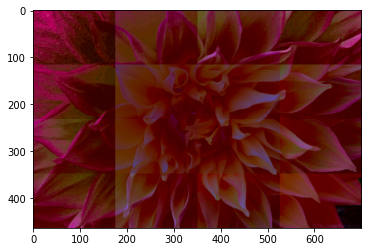

In [232]:
from google.colab.patches import cv2_imshow
#merging split images
son=[]
for i in range(len(sources)):
  liste=[]
  for j in range(len(sources[0])):
    transfer=renklendirme(sources[i][j],targets[index[i][j][0]][index[i][j][1]])
    res=cv2.cvtColor(transfer.astype("uint8"),cv2.COLOR_LAB2RGB)
    liste.append(res)
  result=cv2.hconcat(liste)
  son.append(result)
lastimage=cv2.vconcat(son)
#lastimage=cv2.cvtColor(lastimage,cv2.COLOR_BGR2RGB)
plt.imshow(lastimage)
plt.savefig("4x4.png")